In [38]:
import random
import torch
from torch import nn
from torchvision import datasets
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

In [39]:
# Define the input dimension
X_dim = 28*28 # 784
# Define the output dimension
digit_quantity = 10
# Define the layer sizes in the network
classifier_layers = [X_dim, 512, 64, digit_quantity]

In [40]:
class Classifier(nn.Module):
    def __init__(self, layers):
        super().__init__()
        # Creates a list that can hold layers
        self.layers = nn.ModuleList()
        # Inserts each layer into the list as defined above
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
    def forward(self, x):
        # Runs the input through each layer sequentially
        for i, layer in enumerate(self.layers):
            if i == len(self.layers)-1:
                # Sigmoid is commonly used on the last layer
                # of a network in classification tasks
                return torch.sigmoid(layer(x))
            else:
                # Relu is commonly used in hidden layers
                x = torch.relu(layer(x))

In [41]:
# Datasets

# MNIST is already normalized, so we won't normalize here
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Obtain train_dataset
train_dataset = datasets.MNIST(
   root="./mnist",
   train=True,
   transform=transform,
   download=True,
)

# Obtain test_dataset
test_dataset = datasets.MNIST(
   root="./mnist",
   train=False,
   transform=transform,
   download=True,
)


# Split the training dataset into training and validation sets
# 80% train, 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# These loaders help us easily acces the data when training
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

In [42]:
# Initialize the neural network with specified layers
classifier = Classifier(classifier_layers)
# Put the neural network on the GPU (if available) for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier.to(device)
# Learning Rate set
lr = 1e-3
# Optimizer helps with gradient descent
optimizer = optim.Adam(classifier.parameters(), lr=lr)
# Learning rate is multiplied by .95 each epoch through the lr_scheduler
lambda1 = lambda epoch: 0.95
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda1)
# Cross entropy loss is commonly used in classification problems
loss_function = nn.CrossEntropyLoss()

In [43]:
# This is used on val_loader and test_loader
def calculate_accuracy(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 784).to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    accuracy = correct / total
    return accuracy

In [44]:
# Epochs: Number of times we will train on the entirety of the train dataset
epochs = 20
for epoch in range(epochs):
    total_loss = 0
    total_correct = 0
    total_samples = 0
    for i, (batch_features, batch_labels) in enumerate(train_loader):

        # Resize batch_features
        batch_features = batch_features.view(-1, 784).to(device)

        # Reset the gradients back to zero
        classifier.zero_grad()

        # Pass the images into the classifier
        output = classifier(batch_features)

        # Convert labels into one hot vectors
        #                        0  1  2  3  4  5  6  7  8  9
        # The number 4 would be [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
        digit_tensors = torch.tensor(batch_labels)
        digit_tensors = F.one_hot(digit_tensors, num_classes=10)

        # Calculate loss given batch_labels
        train_loss = loss_function(output.float(), digit_tensors.float())
        train_loss.backward()
        optimizer.step()
        total_loss += train_loss

        # Calculate accuracy on training set
        _, predicted = torch.max(output.data, 1)
        total_correct += (predicted == batch_labels).sum().item()
        total_samples += batch_labels.size(0)

    # Calculate and print accuracy on validation set
    val_accuracy = calculate_accuracy(classifier, val_loader)
    print("Epoch: {}/{} | Train Loss: {:.4f} | Val Acc: {:.4f}".format(epoch + 1, epochs, total_loss, val_accuracy))

# Test the model on the test set
test_accuracy = calculate_accuracy(classifier, test_loader)
print("Test Accuracy: {:.4f}".format(test_accuracy))

# Save the model
torch.save(classifier, "classifier.pt")

/var/folders/lb/ty5nmpy919sdwgwxgrrt5b4m0000gn/T/ipykernel_77562/1385877486.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  digit_tensors = torch.tensor(batch_labels)


Epoch: 1/20 | Train Loss: 604.1215 | Val Acc: 0.9315
Epoch: 2/20 | Train Loss: 568.5425 | Val Acc: 0.9492
Epoch: 3/20 | Train Loss: 562.5635 | Val Acc: 0.9595
Epoch: 4/20 | Train Loss: 559.0175 | Val Acc: 0.9663
Epoch: 5/20 | Train Loss: 556.8624 | Val Acc: 0.9668
Epoch: 6/20 | Train Loss: 555.3080 | Val Acc: 0.9712
Epoch: 7/20 | Train Loss: 554.1187 | Val Acc: 0.9720
Epoch: 8/20 | Train Loss: 553.3167 | Val Acc: 0.9763
Epoch: 9/20 | Train Loss: 552.6130 | Val Acc: 0.9768
Epoch: 10/20 | Train Loss: 551.9981 | Val Acc: 0.9767
Epoch: 11/20 | Train Loss: 551.5899 | Val Acc: 0.9798
Epoch: 12/20 | Train Loss: 551.1475 | Val Acc: 0.9786
Epoch: 13/20 | Train Loss: 550.9310 | Val Acc: 0.9804
Epoch: 14/20 | Train Loss: 550.5659 | Val Acc: 0.9795
Epoch: 15/20 | Train Loss: 550.3659 | Val Acc: 0.9808
Epoch: 16/20 | Train Loss: 550.3022 | Val Acc: 0.9812
Epoch: 17/20 | Train Loss: 550.1337 | Val Acc: 0.9823
Epoch: 18/20 | Train Loss: 549.9750 | Val Acc: 0.9828
Epoch: 19/20 | Train Loss: 549.8860 |

In [45]:
# Load the model
classifier = torch.load("classifier.pt").to(device)

In [46]:
import matplotlib.pyplot as plt
import numpy as np


def display_image(image):
    image = image.detach()
    image = image.view(1, 28, 28)   
    image = image.numpy()
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image)
    plt.show()

In [47]:
def find_number_in_dataset(number):
    for i in range(len(test_dataset)):
        current_number = test_dataset[i][1]
        if current_number == number:
            return test_dataset[i][0]

images = []
for i in range(10):
    images.append(find_number_in_dataset(i))

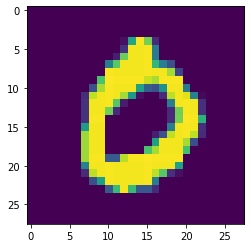

tensor([[1.0000e+00, 1.4033e-21, 1.2631e-11, 3.3819e-19, 1.6728e-10, 1.6953e-14,
         5.4850e-12, 9.3869e-08, 6.8524e-24, 1.5426e-11]],
       grad_fn=<SigmoidBackward0>)


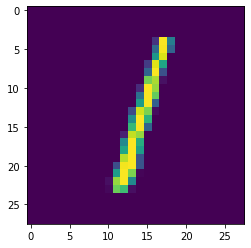

tensor([[1.3708e-12, 1.0000e+00, 4.1418e-09, 4.1256e-12, 1.1389e-08, 6.5875e-11,
         6.5830e-09, 5.4752e-07, 4.9627e-07, 1.8390e-15]],
       grad_fn=<SigmoidBackward0>)


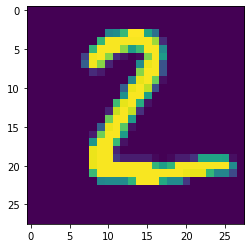

tensor([[1.3527e-16, 6.1441e-11, 1.0000e+00, 3.2555e-11, 4.0200e-32, 2.7727e-24,
         1.5649e-21, 5.9774e-16, 1.0277e-17, 2.8715e-28]],
       grad_fn=<SigmoidBackward0>)


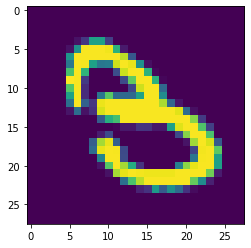

tensor([[1.4126e-11, 2.9228e-09, 2.6785e-07, 9.9997e-01, 3.3944e-10, 6.0227e-11,
         6.5182e-20, 1.4609e-09, 3.9402e-03, 3.5958e-06]],
       grad_fn=<SigmoidBackward0>)


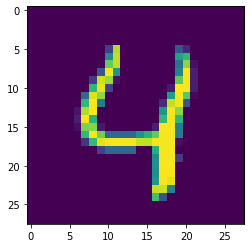

tensor([[6.6707e-14, 1.6740e-10, 5.9272e-15, 4.9516e-19, 1.0000e+00, 4.5985e-12,
         7.7685e-12, 1.0398e-09, 5.6322e-13, 7.6419e-02]],
       grad_fn=<SigmoidBackward0>)


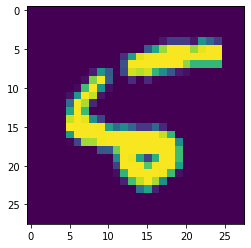

tensor([[1.6859e-16, 3.7017e-14, 2.5979e-16, 4.5690e-26, 2.2461e-09, 5.5703e-01,
         6.2353e-01, 2.7816e-26, 1.0803e-09, 1.0813e-12]],
       grad_fn=<SigmoidBackward0>)


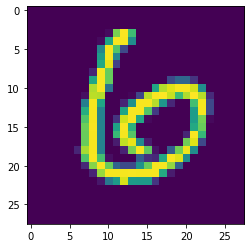

tensor([[7.2266e-11, 7.6581e-11, 1.0644e-10, 3.6047e-20, 2.1452e-14, 6.8176e-10,
         1.0000e+00, 1.5332e-14, 1.9861e-09, 6.2305e-22]],
       grad_fn=<SigmoidBackward0>)


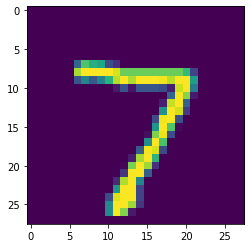

tensor([[8.8938e-18, 1.7715e-13, 1.2628e-14, 5.4096e-13, 6.6567e-26, 5.1373e-23,
         7.9715e-28, 1.0000e+00, 1.7140e-19, 4.9452e-13]],
       grad_fn=<SigmoidBackward0>)


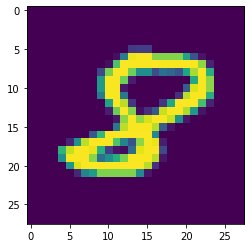

tensor([[5.7803e-15, 4.7632e-11, 1.4097e-03, 8.5138e-08, 7.1592e-18, 4.8150e-12,
         1.5204e-17, 7.1276e-07, 1.0000e+00, 2.7747e-16]],
       grad_fn=<SigmoidBackward0>)


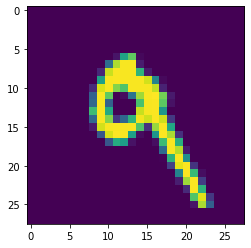

tensor([[2.4338e-09, 1.3958e-11, 2.3413e-08, 6.8201e-06, 1.8169e-06, 1.7672e-13,
         1.4506e-16, 1.0663e-08, 9.4918e-11, 9.9998e-01]],
       grad_fn=<SigmoidBackward0>)


In [48]:
# This shows an input with the model's output
# The output's max value's index should be the value of the number displayed
for i in range(digit_quantity):
    display_image(images[i])
    print(classifier(images[i].view(-1, 784)))